## Initialise Notebook

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("talk")

In [3]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [4]:
# attempt load from loading code

loading_code = 'fgfr4_model_raw_simulation'
simulation_data = data_link.get_data_from_code(loading_code)

In [5]:
loading_code = 'fgfr4_ccle_dynamic_features'
dynamic_features = data_link.get_data_from_code(loading_code)

## Analysis Chain

In [16]:
### OPTIONS

target_protein = "pAkt"
folder_name = "testFolder"
exp_id = "testExp"
fixed_random_seed = 42 # -1 for no seed
umap_params = {
    # ADD YOUR OWN HERE
    'random_state': fixed_random_seed
}

hbd_params = {
    # ADD YOUR OWN HERE
    'min_cluster_size': 500,
    'min_samples': 10,
}


# plot options
dynamic_plot_cols = 2
ncluster_plot_cols = 2
normalise_simulation_dynamics = False
save_figure = False
projection_show_legend = True

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

c:\Github\ode-biomarker-project\dynamic-marker\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


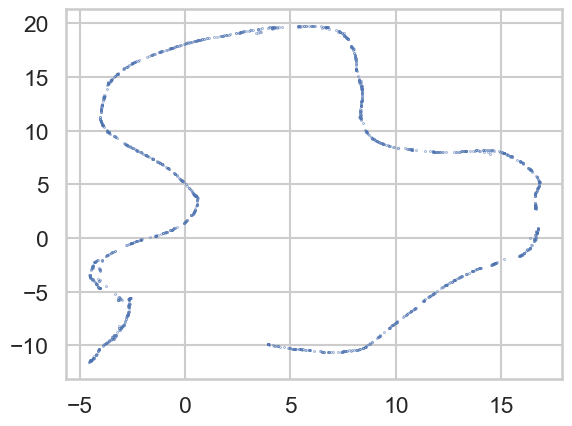

In [7]:
indexed_dyn_feats = dynamic_features.set_index('Row')
target_dynamic_features = indexed_dyn_feats.filter(like=target_protein, axis=1)

dyn_feat_cols = ['auc', 'median', 'tfc', 'tmax', 'max', 'tmin', 'min', 'ttsv', 'tsv', 'init']
joint_dyn_feat_data = []
for row in range(target_dynamic_features.shape[0]):
    ptp_data = target_dynamic_features.iloc[row].tolist()
    joint_dyn_feat_data.append(ptp_data)
    
joint_dynamic_features = pd.DataFrame(joint_dyn_feat_data, columns=dyn_feat_cols)

standard_embedding = umap.UMAP(**umap_params).fit_transform(joint_dynamic_features)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1)

In [13]:
hbd_labels = hdbscan.HDBSCAN(**hbd_params).fit_predict(joint_dynamic_features)

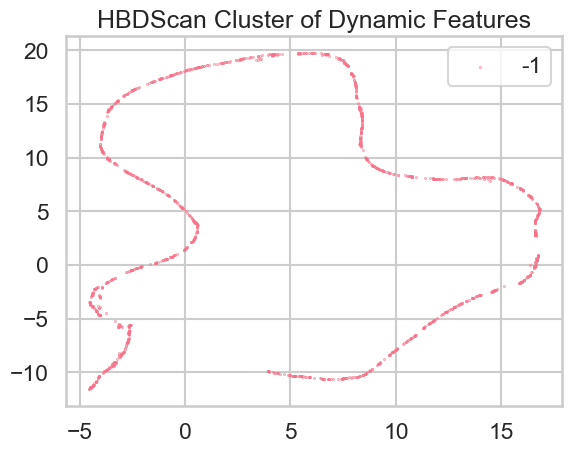

In [17]:
n_clusters = set(hbd_labels)
plot_colors_cluster = sns.color_palette("husl", len(list(n_clusters)))

for k, cluster in enumerate(list(n_clusters)):
    plot_data_x = []
    plot_data_y = []
    for i, label in enumerate(hbd_labels):
        if label == cluster:
            x = standard_embedding[i][0]
            y = standard_embedding[i][1]
            plot_data_x.append(x)
            plot_data_y.append(y)

    plt.scatter(plot_data_x, plot_data_y, color=plot_colors_cluster[k], s=0.2, label=cluster, alpha=0.9) 
    
if projection_show_legend: plt.legend()
plt.title('HBDScan Cluster of Dynamic Features')
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_hbdscan_cluster_{fixed_random_seed}.png')
plt.show()

In [19]:
all_celllines = simulation_data['Cellline'].unique()
all_proteins = simulation_data.columns[2:]

protein_df_data = []

count = 0
for cellline in all_celllines:
    for protein in all_proteins:
        if protein == 'pAkt':
            cellline_protein_data = simulation_data[(simulation_data['Cellline'] == cellline)]
            protein_data = cellline_protein_data[protein]
            protein_df_data.append(protein_data.tolist())

time_column_df = pd.DataFrame(protein_df_data, columns=cellline_protein_data['Time'])

<AxesSubplot: xlabel='Time'>

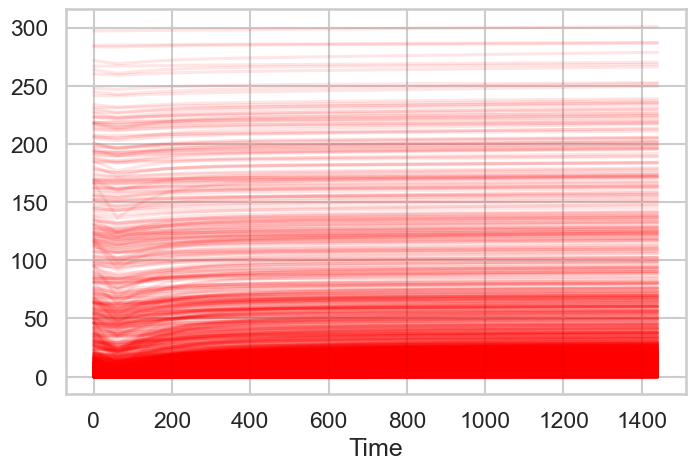

In [20]:
# plot time column df 

time_column_df = time_column_df.T
time_column_df.plot(legend=False, alpha=0.1, color='red', figsize=(8, 5))

In [22]:
mean_df = joint_dynamic_features.mean()

In [23]:
mean_df

auc       0.032610
median    0.036789
tfc       8.290536
tmax      0.999316
max       0.053625
tmin      0.040000
min       0.007289
ttsv      0.058775
tsv       0.012989
init      0.007289
dtype: float64

In [24]:
std_df = joint_dynamic_features.std()
std_df

auc        0.035115
median     0.039886
tfc       26.693915
tmax       0.025621
max        0.054862
tmin       0.000000
min        0.017719
ttsv       0.086293
tsv        0.038759
init       0.017719
dtype: float64

In [38]:
# calculate the relative standard deviation

rsd_df = std_df / mean_df

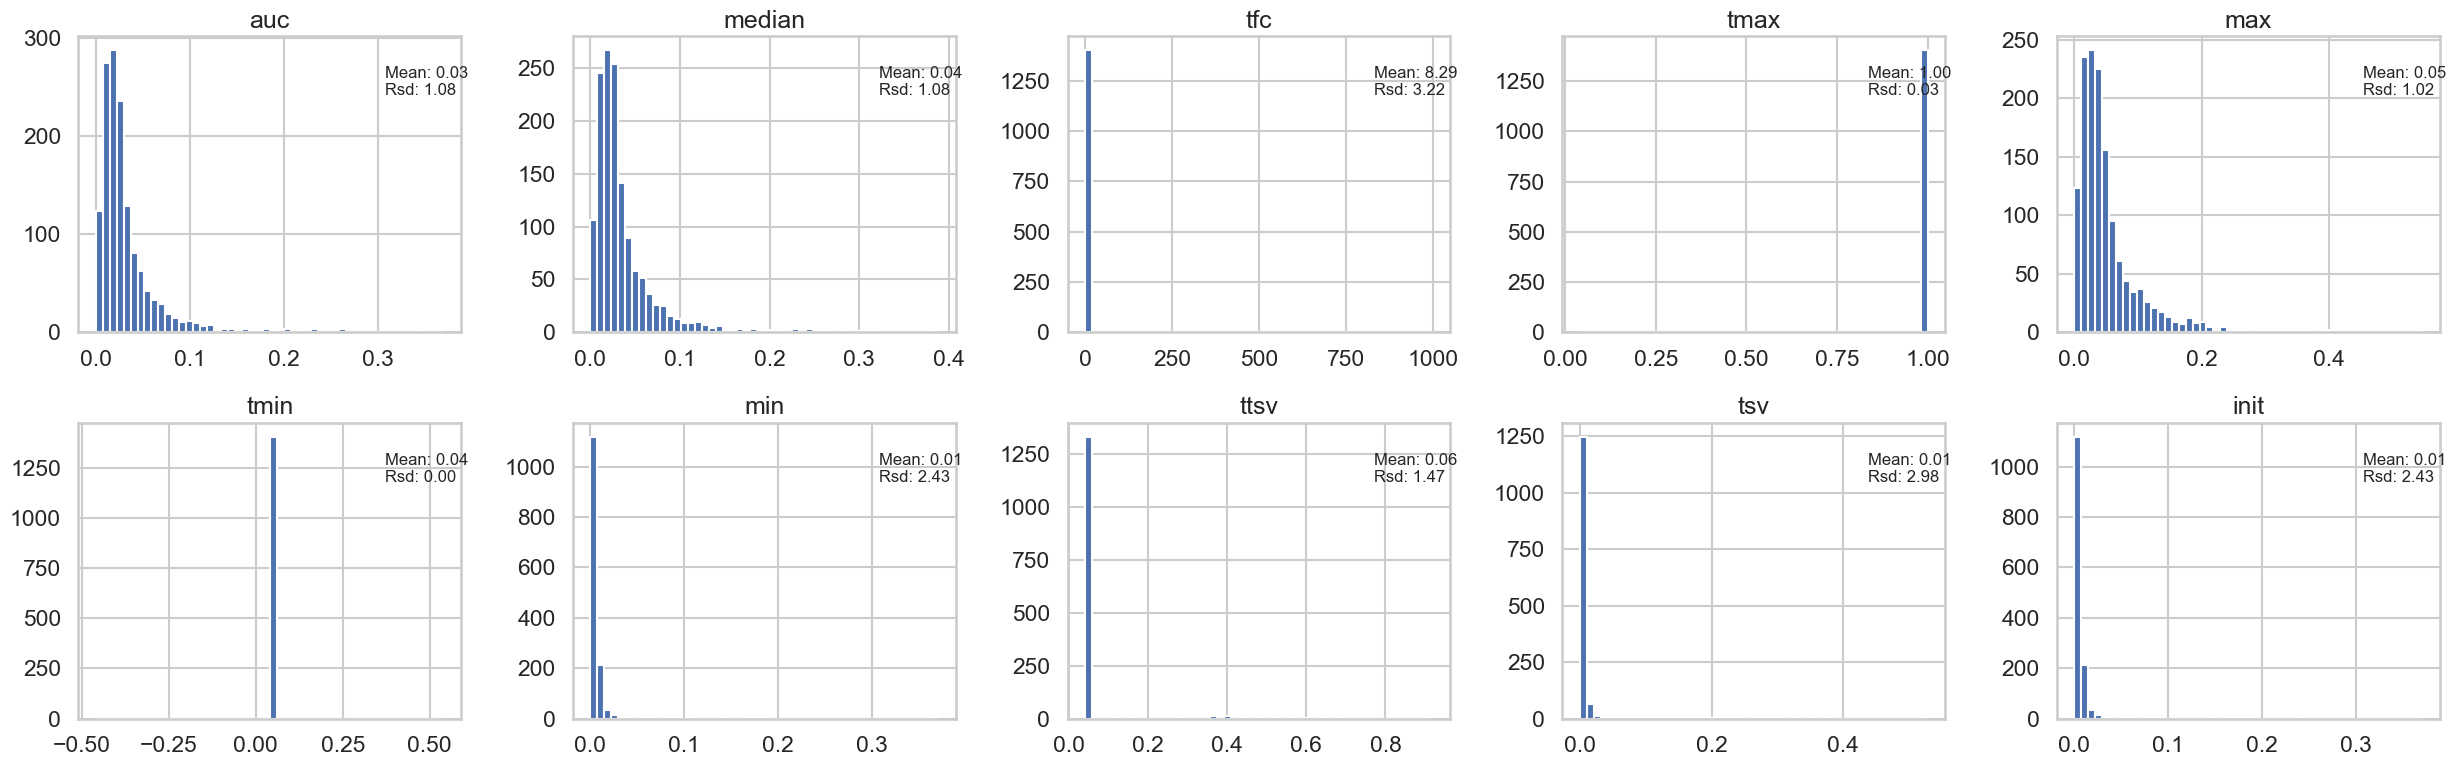

In [42]:
# for each column in joint_dynamic_features, plot histogram of values
import math 

plot_cols = 5
plot_rows = 2
plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))

for i, col in enumerate(mean_df.index):
    plt.subplot(plot_rows, plot_cols, i+1)
    plt.hist(joint_dynamic_features[col], bins=50)
    plt.text(0.8, 0.8, f'Mean: {mean_df[col]:.2f}\nRsd: {rsd_df[col]:.2f}', fontsize=12, transform=plt.gca().transAxes)
    plt.title(col)
    
plt.tight_layout()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_histograms_{fixed_random_seed}.png')
plt.show()
    